C:\Users\user\Documents\10acadamy\week_two\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


         social_media_data   google_data    email_data  youtube_data  \
cluster                                                                
0             2.114848e+11  6.771296e+11  2.107985e+11  1.367864e+12   
1             1.937715e+09  6.007942e+09  1.904048e+09  1.249464e+10   
2             5.587755e+10  1.794811e+11  5.605855e+10  3.647635e+11   

         netflix_data   gaming_data    other_data  
cluster                                            
0        1.366979e+12  4.945871e+13  4.955500e+13  
1        1.228898e+10  4.527450e+11  4.419283e+11  
2        3.647715e+11  1.339567e+13  1.316857e+13  


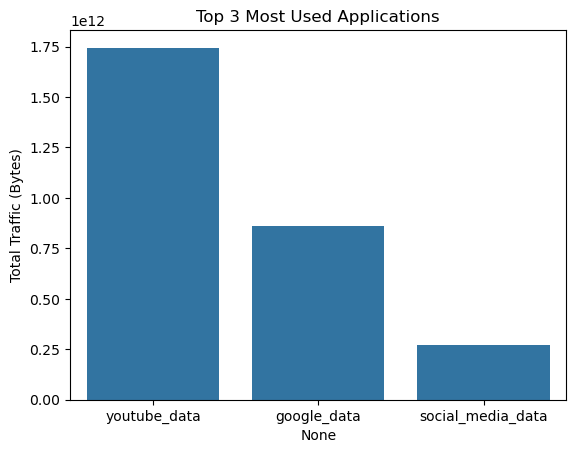

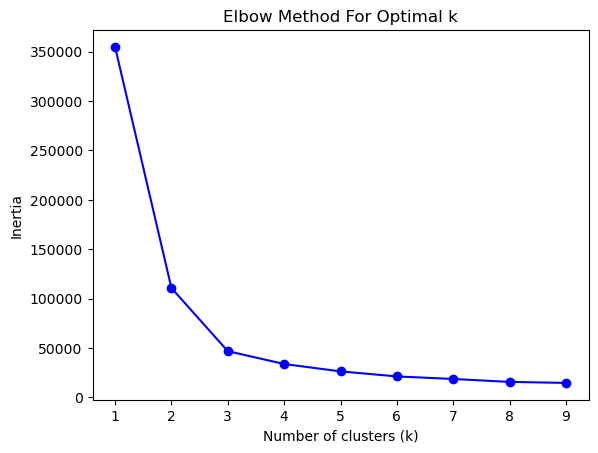

Silhouette Score: 0.8029270765119072


In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Add 'scripts' folder to the Python path for loading data
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
from load_data import load_data_from_postgres

# Step 1: Load User Engagement Data
def load_user_engagement_data():
    query = '''
    SELECT "MSISDN/Number" as customer_id, COUNT("Bearer Id") as session_frequency, 
           SUM("Dur. (ms)") as session_duration,
           SUM("Total DL (Bytes)" + "Total UL (Bytes)") as total_traffic,
           SUM("Social Media DL (Bytes)") as social_media_data, 
           SUM("Google DL (Bytes)") as google_data,
           SUM("Email DL (Bytes)") as email_data, 
           SUM("Youtube DL (Bytes)") as youtube_data,
           SUM("Netflix DL (Bytes)") as netflix_data, 
           SUM("Gaming DL (Bytes)") as gaming_data,
           SUM("Other DL (Bytes)") as other_data
    FROM xdr_data
    GROUP BY customer_id;
    '''
    df = load_data_from_postgres(query)
    return df

df_user_engagement = load_user_engagement_data()

# Step 2: Data Preprocessing
def preprocess_data(df):
    # Fill missing values
    df.fillna(0, inplace=True)
    
    # Scaling features for clustering
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[['session_frequency', 'session_duration', 'total_traffic']]),
                             columns=['session_frequency', 'session_duration', 'total_traffic'])
    return df_scaled, df

df_scaled, df_user_engagement = preprocess_data(df_user_engagement)

# Step 3: Perform K-means Clustering (k=3)
def perform_kmeans(df, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(df)
    return df, kmeans

df_clustered, kmeans = perform_kmeans(df_scaled)

# Analyze Clusters: Aggregate traffic per application per cluster
def analyze_clusters(df_original, df_clustered):
    df_original['cluster'] = df_clustered['cluster']
    cluster_analysis = df_original.groupby('cluster').agg({
        'social_media_data': 'sum',
        'google_data': 'sum',
        'email_data': 'sum',
        'youtube_data': 'sum',
        'netflix_data': 'sum',
        'gaming_data': 'sum',
        'other_data': 'sum'
    })
    return cluster_analysis

cluster_analysis = analyze_clusters(df_user_engagement, df_clustered)
print(cluster_analysis)

# Step 4: Plot Top 3 Most Used Applications
def plot_top_3_applications(cluster_analysis):
    top_apps = cluster_analysis[['social_media_data', 'google_data', 'youtube_data']].sum().sort_values(ascending=False)
    
    # Plot top 3 apps across all clusters
    sns.barplot(x=top_apps.index, y=top_apps.values)
    plt.title("Top 3 Most Used Applications")
    plt.ylabel("Total Traffic (Bytes)")
    plt.show()

plot_top_3_applications(cluster_analysis)

# Step 5: Optimize k-value using the Elbow Method
def find_optimal_k(df_scaled):
    inertia = []
    K = range(1, 10)  # Test k values from 1 to 10
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plot Elbow Graph
    plt.plot(K, inertia, 'bo-')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

find_optimal_k(df_scaled)

# Optional: Evaluate K-means using silhouette score
def evaluate_kmeans(df_scaled, kmeans):
    score = silhouette_score(df_scaled, kmeans.labels_)
    print(f"Silhouette Score: {score}")

evaluate_kmeans(df_scaled, kmeans)
